In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
#path_wd='./drive/MyDrive/MineriaIII'
#os.chdir(path_wd)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import cv2
import re
from sklearn.decomposition import PCA
from umap import UMAP
from tensorflow.keras.models import save_model, load_model
import scipy
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
sns.set_theme()

path_models='models/'
path_pred='predictions/'
path_data='Sentinel2LULC_354/'
path_test='Test 2/'
ext_sub = '.csv'

print(np.__version__)

1.20.3


In [3]:
label_groups = {1:1, 2:2, 3:3, 4:4,5:4, 6:5,7:5,8:5,9:5,10:5,11:5,12:5,13:5,14:5,15:5,16:5,17:5, 
                18:6,19:6,20:6, 21:7,22:7, 23:8, 24:9,25:9,26:9,27:9,28:9, 29:10}
subgroup = 9

In [4]:
data = []
labels = []

for d in os.listdir(path_data):
    lab = int(re.search('\d{1,2}', d).group())
    if label_groups.get(lab) == subgroup:
        for f in os.listdir(path_data + d):
            try:
                img = cv2.imread(path_data + d + '/' + f)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(img)
                labels.append(lab)
            except:
                print("Cannot read file: " + d + '/' + f)

data = np.array(data)
labels = np.array(labels)

In [7]:
test_data = []
test_labels = []

for f in os.listdir(path_test):
    lab = int(re.search('^(\d{1,2})_', f).group(1))
    if label_groups.get(lab) == subgroup:
        try:
            img = cv2.imread(path_test + f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            test_data.append(img)
            test_labels.append(lab)
        except:
            print("Cannot read file: " + f)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [8]:
train, val = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels)
train_data = data[train]
train_labels = labels[train]
val_data = data[val]
val_labels = labels[val]

In [9]:
train_data = train_data.reshape(train_data.shape[0], -1)/255.0
val_data = val_data.reshape(val_data.shape[0], -1)/255.0
test_data = test_data.reshape(test_data.shape[0], -1)/255.0

In [26]:
umap = UMAP(n_neighbors=15, n_components=10, metric='euclidean').fit(train_data)
train_prec = umap.transform(train_data)
val_prec = umap.transform(val_data)
test_prec = umap.transform(test_data)

In [33]:
pca = PCA().fit(train_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [35]:
train_prec = pca.transform(train_data)[:,0:d]
val_prec = pca.transform(val_data)[:,0:d]
test_prec = pca.transform(test_data)[:,0:d]

In [36]:
batch_size = 16
shuffle_buffer_size = 1000

nclasses = len(np.unique(labels))
factor_labels = np.min(labels)
if nclasses > 2:
    train_labels_coded = tf.one_hot(train_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
    val_labels_coded = tf.one_hot(val_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
    test_labels_coded = tf.one_hot(test_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
else:
    train_labels_coded = train_labels-factor_labels
    val_labels_coded = val_labels-factor_labels
    test_labels_coded = test_labels-factor_labels

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_prec), tf.convert_to_tensor(train_labels_coded)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_prec), tf.convert_to_tensor(val_labels_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_prec), tf.convert_to_tensor(test_labels_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

In [44]:
def create_model(binary=False):
    if binary:  
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(nclasses)
        ])
    return model


def train_evaluate_model(model, name, binary=False, lr=0.0001):
    if binary:
        metric = 'binary_accuracy'
        metric_val = 'val_binary_accuracy' 
    else:
        metric = 'categorical_accuracy'
        metric_val = 'val_categorical_accuracy'

    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor=metric_val,
        verbose=1,
        mode='max',
        patience=10,
        restore_best_weights=True
    )
    epochs = 50
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
    if binary:
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        metrics = [tf.keras.metrics.binary_accuracy]
    else:
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        metrics = [tf.keras.metrics.categorical_accuracy]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history = model.fit(train_batches,
                      epochs=epochs, 
                      validation_data=val_batches,
                      callbacks=[earlystopping])

    #save_model(model, path_models + name + '.h5')

    test_loss, test_acc = model.evaluate(test_batches)
    print('Test loss: ' + str(test_loss) + ', test acc: ' + str(test_acc))

    if binary:
        val_preds = (model.predict(val_batches) > 0.5).astype(int)
        test_preds = (model.predict(test_batches) > 0.5).astype(int)
    else:
        val_preds = np.argmax(model.predict(val_batches), axis=-1)
        test_preds = np.argmax(model.predict(test_batches), axis=-1)
        val_matrix = tf.math.confusion_matrix(val_labels-factor_labels, val_preds)
        test_matrix = tf.math.confusion_matrix(test_labels-factor_labels, test_preds)

    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    axlabs = [str(l) for l in np.unique(np.sort(train_labels))]

    im = sns.heatmap(ax=ax[0], data=val_matrix, annot=True, fmt="d")
    ax[0].set_xticks(np.arange(nclasses))
    ax[0].set_yticks(np.arange(nclasses))
    ax[0].set_xticklabels(axlabs)
    ax[0].set_yticklabels(axlabs)
    ax[0].set_title("Validation conf matrix")

    im = sns.heatmap(ax=ax[1], data=test_matrix, annot=True, fmt="d")
    ax[1].set_xticks(np.arange(nclasses))
    ax[1].set_yticks(np.arange(nclasses))
    ax[1].set_xticklabels(axlabs)
    ax[1].set_yticklabels(axlabs)
    ax[1].set_title("Test confusion matrix")

    plt.show()
    

def fit_evaluate_svm():
    tuned_parameters = [{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf']}]
    svm = RandomizedSearchCV(SVC(), tuned_parameters)
    svm.fit(train_prec, train_labels)
    
    targets = np.unique(np.sort(train_labels))
    
    val_pred = svm.predict(val_prec)
    print(classification_report(val_labels, val_pred, target_names=targets.astype(str)))
    
    test_pred = svm.predict(test_prec)
    print(classification_report(test_labels, test_pred, target_names=targets.astype(str)))

In [45]:
fit_evaluate_svm()

              precision    recall  f1-score   support

          24       0.64      0.48      0.55        71
          25       0.70      0.67      0.69        70
          26       0.71      0.56      0.63        71
          27       0.44      0.86      0.58        71
          28       0.79      0.44      0.56        71

    accuracy                           0.60       354
   macro avg       0.66      0.60      0.60       354
weighted avg       0.66      0.60      0.60       354

              precision    recall  f1-score   support

          24       0.87      0.54      0.67        50
          25       0.78      0.87      0.82        62
          26       0.53      0.36      0.43        50
          27       0.58      0.98      0.73        61
          28       1.00      0.75      0.85        55

    accuracy                           0.72       278
   macro avg       0.75      0.70      0.70       278
weighted avg       0.75      0.72      0.71       278



Epoch 1/50
89/89 [==============================] - 1s 7ms/step - loss: 1.2880 - categorical_accuracy: 0.4421 - val_loss: 0.9741 - val_categorical_accuracy: 0.6017
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 0.9821 - categorical_accuracy: 0.5833 - val_loss: 0.8951 - val_categorical_accuracy: 0.5791
Epoch 3/50
89/89 [==============================] - 0s 6ms/step - loss: 0.8809 - categorical_accuracy: 0.6278 - val_loss: 0.8765 - val_categorical_accuracy: 0.5791
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 0.8064 - categorical_accuracy: 0.6589 - val_loss: 0.8217 - val_categorical_accuracy: 0.6582
Epoch 5/50
89/89 [==============================] - 1s 6ms/step - loss: 0.7527 - categorical_accuracy: 0.6751 - val_loss: 0.8566 - val_categorical_accuracy: 0.6073
Epoch 6/50
89/89 [==============================] - 1s 6ms/step - loss: 0.6815 - categorical_accuracy: 0.7182 - val_loss: 0.8546 - val_categorical_accuracy: 0.6017
Epoch 7/50
89/89

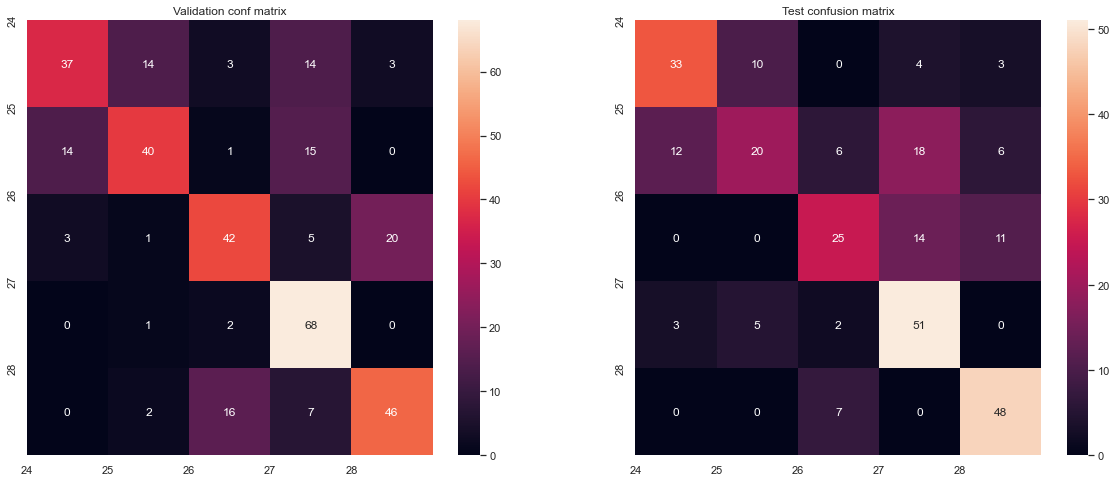

In [39]:
model = create_model()
train_evaluate_model(model, 'crop')